In [71]:
import pandas as pd
train = pd.read_csv('house.csv')
test = pd.read_csv('house.test.csv')
train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [73]:
numerical_cols = [i for i in train_X.columns if train_X[i].dtype in ['int64', 'float64']]
categorical_cols = [i for i in train_X.columns if train_X[i].nunique() < 20 and train_X[i].dtype == 'object']
my_cols = numerical_cols+categorical_cols
train_X = train_X[my_cols]

In [75]:
from sklearn.impute import SimpleImputer
X = train[my_cols]
imp = SimpleImputer(strategy='most_frequent')
X = imp.fit_transform(X)
X = pd.DataFrame(X, columns=my_cols)
Y = train.SalePrice
for i in X.select_dtypes('object'):
    X[i], _ = X[i].factorize()
discrete_features = X.dtypes == int

In [76]:
from sklearn.feature_selection import mutual_info_regression
def mutal_info(X, Y, discrete_features):
    info = mutual_info_regression(X, Y, discrete_features=discrete_features)
    info = pd.Series(info, name='mutual_info', index = X.columns)
    info = info.sort_values(ascending=False)
    return info

In [81]:
mi_scores = mutal_info(X, Y, discrete_features)
mi_scores[::3]

OverallQual      5.744453e-01
YearBuilt        4.078247e-01
GarageCars       3.564084e-01
BsmtQual         3.166098e-01
1stFlrSF         2.811537e-01
GarageFinish     2.364862e-01
Foundation       1.938779e-01
Fireplaces       1.632155e-01
Exterior2nd      1.570953e-01
GarageType       1.268342e-01
OverallCond      1.126458e-01
LotShape         9.107610e-02
HalfBath         7.944995e-02
BedroomAbvGr     7.509601e-02
MasVnrType       5.917710e-02
BldgType         4.476359e-02
LandContour      2.393284e-02
EnclosedPorch    2.190631e-02
GarageCond       2.055643e-02
GarageQual       1.496314e-02
BsmtHalfBath     1.121894e-02
YrSold           9.134808e-03
Functional       5.799385e-03
3SsnPorch        2.355333e-03
Utilities        1.887379e-15
MoSold           0.000000e+00
Name: mutual_info, dtype: float64

In [85]:
import matplotlib.pyplot as plt
import numpy as np
def mi_plot(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title('Mutal Information Scores')

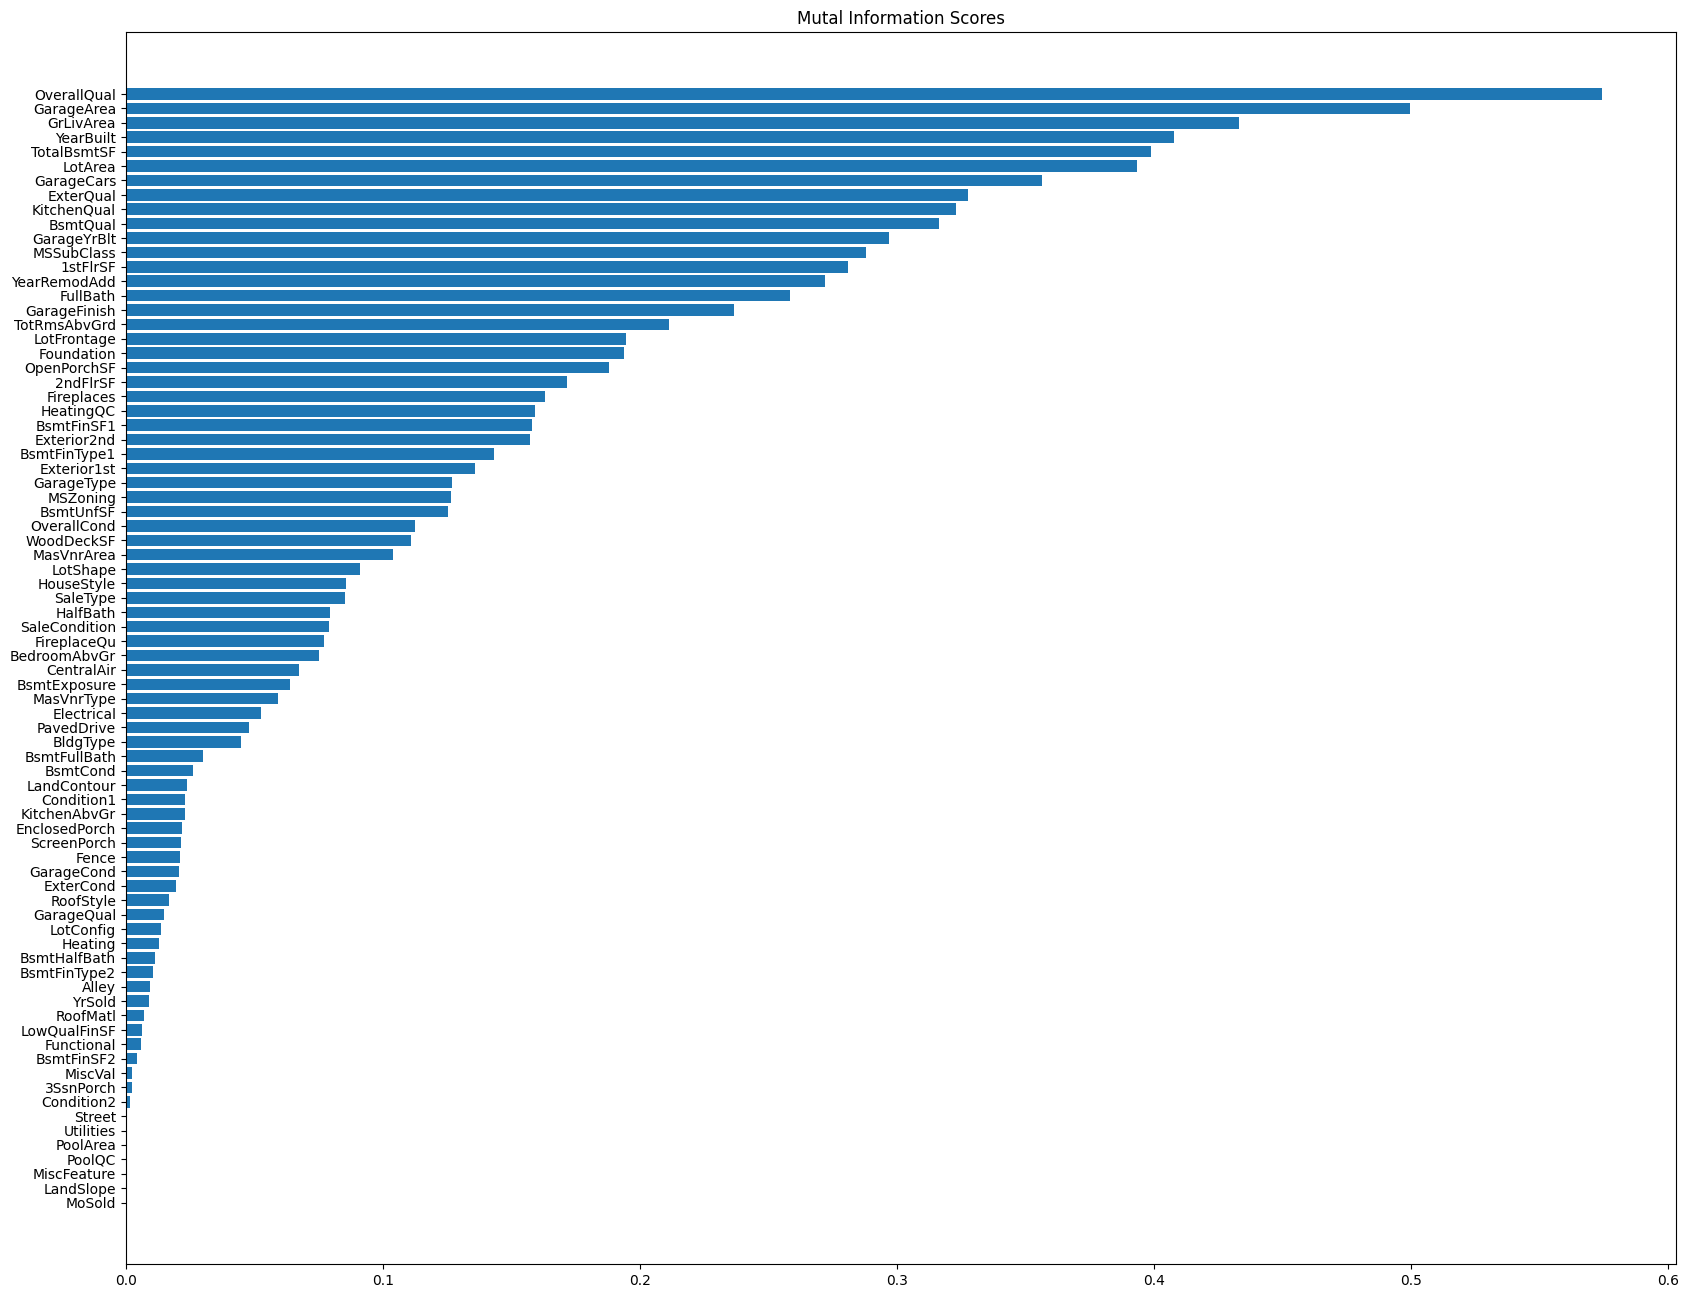

In [89]:
plt.figure(dpi=100, figsize=(20,16))
mi_plot(mi_scores)

In [72]:
features = train.columns.drop('Id')
train_X = train[features.drop('SalePrice')]
train_Y = train.SalePrice

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
numerical = SimpleImputer(strategy='constant')
categorical = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('hot', OneHotEncoder(handle_unknown='ignore'))
])
preprocess = ColumnTransformer(transformers=[
    ('num', numerical, numerical_cols),
    ('cat', categorical, categorical_cols)
])

In [31]:
from xgboost import XGBRegressor
model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', XGBRegressor(n_estimators=400 , learning_rate=0.3))
])
model.fit(train_X, train_Y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [32]:
pred = model.predict(test)

In [33]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, train_X, train_Y, cv = 5, scoring='r2')
print(f"Accuracy score: {scores}")

Accuracy score: [0.87713432 0.83885837 0.88138437 0.89793658 0.83998048]


In [34]:
scores.mean()

np.float64(0.8670588254928588)

In [35]:
from sklearn.ensemble import RandomForestRegressor
model2 = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', RandomForestRegressor(n_estimators=400, random_state=0))
])
model2.fit(train_X, train_Y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [36]:
pred2 = model2.predict(test)
scores2 = cross_val_score(model2, train_X, train_Y, cv = 5, scoring='r2')
print(f"Accuracy score: {scores2}")

Accuracy score: [0.8725019  0.8427621  0.87419224 0.88051266 0.80997687]


In [40]:
scores2.mean()

np.float64(0.8559891550415657)

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64